# CSC490 Report – Group name: Team 8 – Skin Cancer Challengers
Team members: 
- Arthur Alexandro Soenarto
- Gabriel El Haddad
- Xiaoning Wang
- Syed Taha Ali

## Name of dataset:  Skin Cancer MNIST: HAM10000
- Paper reference(s):
[Disease Classification based on Dermoscopic Skin Images Using Convolutional Neural Network in Teledermatology System](https://ieeexplore.ieee.org/abstract/document/8973303)
[Skin Lesion Analysis Toward Melanoma Detection 2018: A Challenge Hosted by the International Skin Imaging Collaboration (ISIC)](https://arxiv.org/abs/1902.03368)

- Location of the dataset:  https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000


In [5]:
pip install opendatasets --user

  Using cached opendatasets-0.1.22-py3-none-any.whl (15 kB)
  Using cached kaggle-1.5.12.tar.gz (58 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached certifi-2022.9.24-py3-none-any.whl (161 kB)
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
Using legacy 'setup.py install' for kaggle, since package 'wheel' is not installed.
  Running setup.py install for kaggle: started
  Running setup.py install for kaggle: finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Python310\python.exe -m pip install --upgrade pip' command.


In [20]:
pip install -U matplotlib --user

Note: you may need to restart the kernel to use updated packages.


In [9]:
!pip install imblearn --user

     -------------------------------------- 199.3/199.3 kB 4.1 MB/s eta 0:00:00
     -------------------------------------- 298.0/298.0 kB 9.0 MB/s eta 0:00:00
     ---------------------------------------- 7.5/7.5 MB 7.9 MB/s eta 0:00:00
     ---------------------------------------- 40.1/40.1 MB 5.6 MB/s eta 0:00:00


In [12]:
!pip install sklearn --user

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py install for sklearn: started
  Running setup.py install for sklearn: finished with status 'done'


  DEPRECATION: sklearn is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559


In [1]:
import pandas as pd
# from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [3]:
data = pd.read_csv('./skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
data

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [4]:
"""~66% of the samples belong to 1 of the 7 classes"""
data["dx"].value_counts() / np.sum(data["dx"].value_counts()) * 100

nv       66.949576
mel      11.113330
bkl      10.973540
bcc       5.132302
akiec     3.265102
vasc      1.417873
df        1.148278
Name: dx, dtype: float64

In [5]:
"""
Since the final output target is the diagnosis, we need to balanced our dataset so the diagnoses classes
are more balanced. We can start by first removing duplicates from dominant class but keeping them in minority classes.
"""

seen = set()
to_remove_indexes = set()
for index, row in data.iterrows():
    if row['dx'] == "nv" and row['lesion_id'] in seen:
        to_remove_indexes.add(index)
    if row['dx'] == 'nv':
        seen.add(row['lesion_id'])
    
rebalanced_data = data.drop(to_remove_indexes)
rebalanced_data["dx"].value_counts() / np.sum(rebalanced_data["dx"].value_counts()) * 100

nv       62.010788
mel      12.774016
bkl      12.613336
bcc       5.899231
akiec     3.753013
vasc      1.629749
df        1.319867
Name: dx, dtype: float64

In [11]:
"""
Another technique is to randomly over sample the minority classes with replacement, until all the classes have
an equal representation.
"""
from imblearn.over_sampling import RandomOverSampler


x = np.array(rebalanced_data[["lesion_id", "image_id", "age", "sex", "localization"]])
y = np.array(rebalanced_data[["dx"]])
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(x, y)
unique, counts = np.unique(y_res, return_counts=True)
dict(zip(unique, counts))

{'akiec': 5403,
 'bcc': 5403,
 'bkl': 5403,
 'df': 5403,
 'mel': 5403,
 'nv': 5403,
 'vasc': 5403}

In [13]:
from sklearn.model_selection import train_test_split

# First, we will use `train_test_split` to split the data set into
# 32821 training+validation, and 5000 test:
X_tv, X_test, t_tv, t_test = train_test_split(X_res, y_res, test_size=5000/37821)
# Then, use `train_test_split` to split the training+validation data
# into 27821 train and 5000 validation
X_train, X_valid, t_train, t_valid = train_test_split(X_tv, t_tv, test_size=5000/32821)

In [15]:
rgb_df = pd.read_csv('./skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
rgb_df

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,183,165,181,182,165,180,184,166,182,188,...,208,185,187,208,186,186,206,187,189,0
10011,2,3,1,38,33,32,121,104,103,132,...,96,79,76,24,23,21,3,4,1,0
10012,132,118,118,167,149,149,175,156,160,184,...,204,181,178,181,159,153,172,151,145,0
10013,160,124,146,164,131,152,167,127,146,169,...,185,162,167,184,157,166,185,162,172,0


In [17]:
L_df = pd.read_csv('./skin-cancer-mnist-ham10000/hmnist_28_28_L.csv')
L_df

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783,label
0,169,171,170,177,181,182,181,185,194,192,...,184,186,185,180,157,140,140,159,165,2
1,19,57,105,140,149,148,144,155,170,170,...,172,175,160,144,114,89,47,18,18,2
2,155,163,161,167,167,172,155,152,165,175,...,163,178,157,166,167,148,141,136,115,2
3,25,71,116,139,136,153,148,161,172,162,...,125,135,138,137,111,71,32,16,16,2
4,129,162,181,196,205,208,205,213,225,224,...,210,197,172,190,195,193,181,147,88,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,172,171,173,175,164,187,207,210,208,206,...,210,217,221,209,185,187,192,192,192,0
10011,2,34,108,116,114,119,131,139,139,145,...,173,169,168,168,143,138,83,23,3,0
10012,122,154,162,170,179,197,200,195,202,199,...,221,215,205,187,209,198,187,164,156,0
10013,137,143,141,139,147,152,155,152,155,159,...,172,171,175,183,177,170,169,166,170,0


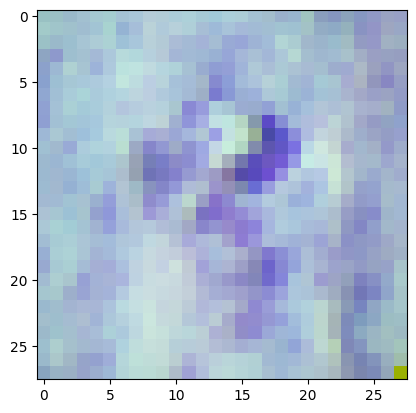

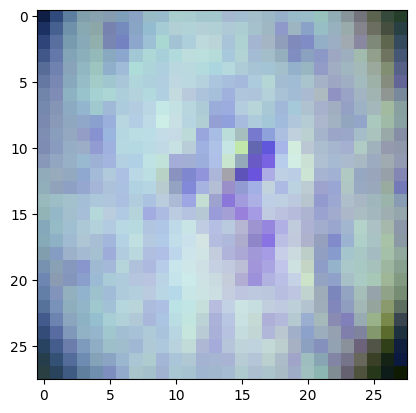

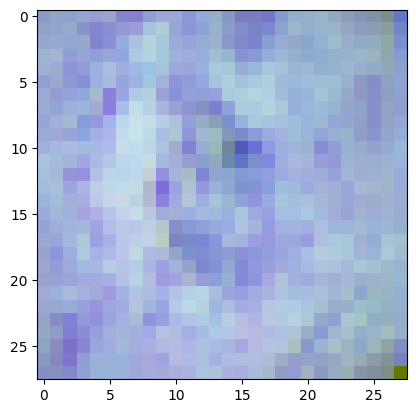

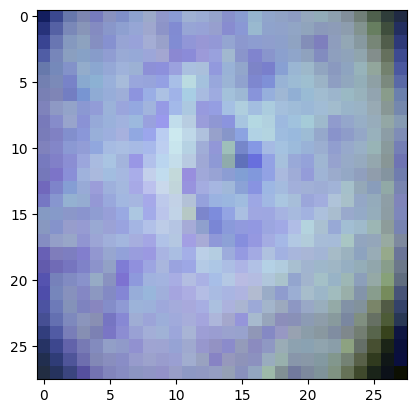

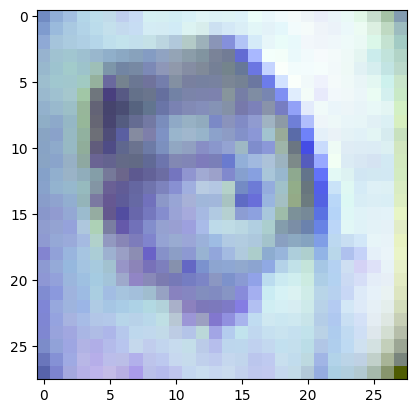

In [18]:
for i in range(0,5):
    sample=np.reshape(rgb_df[rgb_df.columns[1:]].iloc[i].values/255,(28,28,3))
    plt.figure()
    plt.imshow(sample)

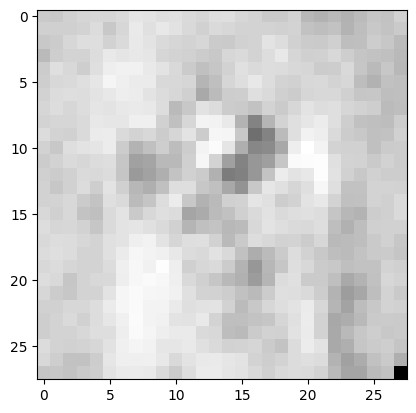

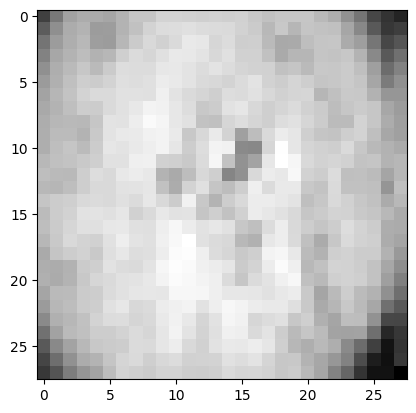

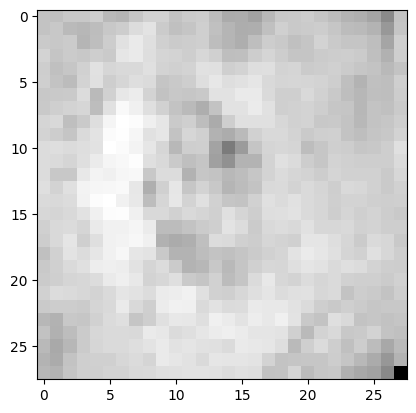

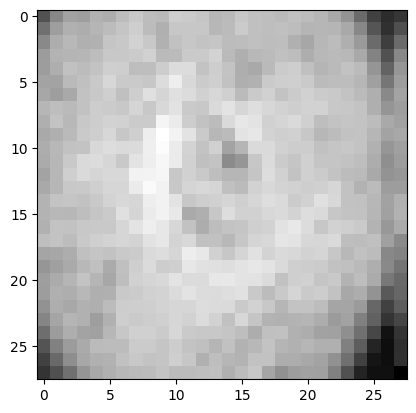

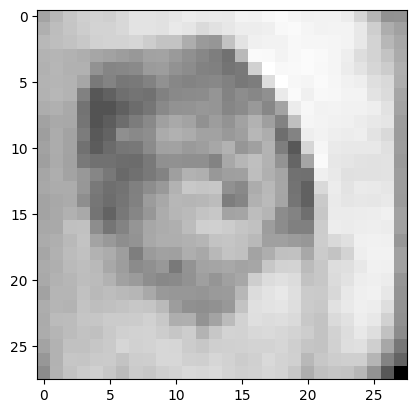

In [19]:
for i in range(0,5):
    sample=np.reshape(L_df[L_df.columns[1:]].iloc[i].values,(28,28))
    # sample = np.expand_dims(sample, axis=0)
    plt.figure()
    plt.imshow(sample, 'gray')